In [1]:
import bioalerts
import numpy as np

In [2]:
from bioalerts import LoadMolecules, Alerts, FPCalculator

In [3]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
# Machine learning modules
import sklearn
from sklearn import preprocessing
import scipy
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

from sklearn.neighbors import KNeighborsRegressor

In [4]:
import sys, numpy as np, scipy as sc, rdkit, matplotlib as pylab, pandas as pd, IPython
print " Python:", sys.version, "\n"
print " Numpy:", np.__version__
print " Scipy:", sc.__version__
print " Rdkit:", rdkit.rdBase.rdkitVersion
print " Matplotlib:", pylab.__version__
print " Pandas:", pd.__version__
print " Ipython:", IPython.__version__
print " Scikit-Learn:", sklearn.__version__
print " Scipy:", scipy.__version__

 Python: 2.7.16 |Anaconda, Inc.| (default, Mar 14 2019, 15:42:17) [MSC v.1500 64 bit (AMD64)] 

 Numpy: 1.16.5
 Scipy: 1.2.1
 Rdkit: 2017.09.1
 Matplotlib: 2.2.3
 Pandas: 0.24.2
 Ipython: 5.8.0
 Scikit-Learn: 0.20.3
 Scipy: 1.2.1


In [5]:
import time
initial_time = time.clock()

# A. Calculating p.values for substructures. Continuous bioactivity values

In [6]:
molecules = bioalerts.LoadMolecules.LoadMolecules("./tutorial/datasets/5AR.smi",name_field=None) 
#COX2.smi is a set of only SMILES data
molecules.ReadMolecules()

Format of the structures file = SMILES
All molecules in the input file were processed correctly


In [7]:
cox_bio = np.genfromtxt('./tutorial/datasets/5AR.bio.txt',skip_header=0) 
#COX2.bio dataset is a set of pIC50 values
# skiprows was removed in version 1.10 Please use skip_header instead.
cox_bio.shape
arr = np.arange(0,len(cox_bio))
mask = np.ones(arr.shape,dtype=bool)
mask[molecules.molserr]=0
cox_bio = cox_bio[mask]
print len(cox_bio)
print len(molecules.mols)

278
278


## A.1.1 base method

In [ ]:
#training, test, bio_training, bio_test = [],[],[],[]

In [8]:

#Please divide with more creative method. 
stride = int(len(molecules.mols) * 0.9)
training = molecules.mols[0:stride]
test = molecules.mols[stride:len(molecules.mols)]
print len(molecules.mols), len(test), len(training)


278 28 250


In [9]:
bio_training = cox_bio[0:stride]
bio_test = cox_bio[stride:len(molecules.mols)]
print len(cox_bio), len(bio_test), len(bio_training)

278 28 250


in this process, we derive the p value from the distribution of test set, 
and derive substructure information with training set and then compare between training and test ,, 
so ,, if we use bootstrapping to total dataset, there are some non-included data. 
that will make wrong results I think

## A.1.2 method (i) - Error when run Alerts_continuous.calculate_p_values function

In [ ]:
def bootstrapping (mol_data, bio_data, test_ratio):
    
    training, test, bio_training, bio_test = [],[],[],[]
    datasize = int(len(mol_data))
    train_size = int(datasize * (1-test_ratio))
    
    if int(len(bio_data)) != datasize : 
        Error = "data size between molecule.mols and bioactivity is not matched. Please confirm it."
        print Error
        return None
    
    train_idx = list(np.random.choice(datasize,size=train_size,replace=False))
    for i in train_idx:
        training.append(mol_data[i])
        bio_training.append(bio_data[i])
        
    for j in range(datasize):
        if j not in train_idx:
            test.append(mol_data[j])
            bio_test.append(bio_data[j])
            
    return training, test, bio_training, bio_test


#Please divide with more creative method. 
training, test, bio_training, bio_test = bootstrapping(molecules.mols, cox_bio, 0.1)
print len(molecules.mols), len(test), len(training)
print len(cox_bio), len(bio_test), len(bio_training)


## A.1.3 method (ii)  - Error when run Alerts_continuous.calculate_p_values function

In [ ]:
training, test, bio_training, bio_test = [],[],[],[]

In [ ]:
train_idx = list(np.random.choice(int(len(molecules.mols)),size=int(len(molecules.mols) * 0.9),replace=False))
test_idx = []
for i in range(int(len(molecules.mols))):
    if i not in train_idx:
        test_idx.append(i)

In [ ]:
#stride = int(len(molecules.mols) * 0.9)
for i in train_idx:
    training.append(molecules.mols[i])
for j in test_idx:
    test.append(molecules.mols[j])
print len(molecules.mols), len(test), len(training)

In [ ]:
for i in train_idx:
    bio_training.append(cox_bio[i])
for j in test_idx:
    bio_test.append(cox_bio[j])
print len(cox_bio), len(bio_test), len(bio_training)

**-------------------------------------------------------------------------------------------------------------------**

## A.2.1 calculate p value with significant substructure 

In [15]:
training_dataset_info = bioalerts.LoadMolecules.GetDataSetInfo(name_field=None)
training_dataset_info.extract_substructure_information(radii=[2,3,4,5,6],mols=training)

In [11]:
Alerts_continuous = bioalerts.Alerts.CalculatePvaluesContinuous(radii_ext=[2,3,4,5,6])

In [12]:
Alerts_continuous.calculate_p_values(mols=test,
                                     substructure_dictionary = training_dataset_info.substructure_dictionary,
                                     bioactivities = bio_training,
                                     mols_ids = molecules.mols_ids[0:stride],
                                     threshold_nb_substructures = 5,
                                     threshold_pvalue = 0.05,
                                     threshold_ratio=0.2)

number of substructures processed:  2442


In [13]:
len(Alerts_continuous.output)

8

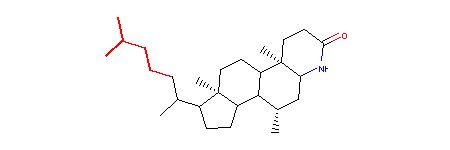

In [14]:
Alerts_continuous.output['Substructure in Molecule'][1]

In [ ]:
Alerts_continuous.output.columns

In [ ]:
Alerts_continuous.XlSXOutputWriter(Alerts_continuous.output,'test_continuous_5AR.xlsx')

## A.2.2 calculate p value with significant substructures which get high activities 

In [23]:
def calculate_bioactivity_threshold(bio,threshold):
    
    sorted_bio = sorted(bio)
    threshold_bio_value = sorted_bio[int(len(sorted_bio)*threshold)]
    return threshold_bio_value

threshold_= 0.6
threshold_bio_value = calculate_bioactivity_threshold(bio_training,threshold_)
threshold_bio_value

7.489991487

In [24]:
Alerts_continuous_high_activity = bioalerts.Alerts.CalculatePvaluesContinuous(radii_ext=[2,3,4,5,6])

In [25]:
Alerts_continuous_high_activity.calculate_p_values_with_bioactivity_threshold(mols=test,
                                     substructure_dictionary = training_dataset_info.substructure_dictionary,
                                     bioactivities = bio_training,
                                     mols_ids = molecules.mols_ids[0:stride],
                                     threshold_nb_substructures = 5,
                                     threshold_pvalue = 0.05,
                                     threshold_ratio=0.2,
                                     threshold_high_act_nb_substructures=10,
                                     threshold_high_act_ratio = 0.6,                                                                        
                                     threshold_bioactivity=threshold_bio_value)

using student's t-test
using student's t-test
using student's t-test
using student's t-test
using student's t-test
using student's t-test
using student's t-test
using student's t-test
number of substructures processed:  2442


In [26]:
len(Alerts_continuous_high_activity.output)

8

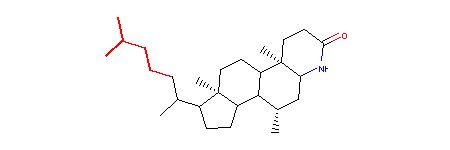

In [27]:
Alerts_continuous_high_activity.output['Substructure in Molecule'][0]

In [27]:
Alerts_continuous_high_activity.output.columns

Index([u'Compound ID', u'Number compounds', u'statistic', u'p_value', u'Diff. distribution means (w - wo)', u'Compounds with substr.', u'Substructure', u'Substructure in Molecule'], dtype='object')

## Alerts_continuous_high_activity.XlSXOutputWriter(Alerts_continuous_high_activity.output,'test_continuous_5AR_high_activity_0.6_10_0.6.xlsx')

# B. Calculating Morgan fingerprints

In this section, we will see how to calculate hashed and unhashed Morgan fingerprints for a set of molecules, and will train __Random Forest models__ on them.

In [ ]:
AR_mols = bioalerts.LoadMolecules.LoadMolecules("./tutorial/datasets/5AR.smi",name_field=None) 
#COX2.smi is a set of only SMILES data

In [ ]:
AR_mols.ReadMolecules()

In [ ]:
AR_bio = np.genfromtxt('./tutorial/datasets/5AR.bio.txt',skip_header=0) 
print len(AR_mols.mols)
print len(AR_bio)

In [ ]:
stride = int(len(AR_mols.mols) * 0.9)
training = AR_mols.mols[0:stride]
test = AR_mols.mols[stride:len(AR_mols.mols)]
print len(AR_mols.mols), len(test), len(training)

bio_training = AR_bio[0:stride]
bio_test = AR_bio[stride:len(AR_mols.mols)]
print len(AR_bio), len(bio_test), len(bio_training)

### B.1 Computating HASHED Morgan fingerprints for the TRAINING set: 

We first initialize the class bioalerts.FPCalculator.CalculateFPs()

In [ ]:
fps_training = bioalerts.FPCalculator.CalculateFPs(radii=[0,1,2],mols=training)

In [ ]:
fps_training.calculate_hashed_fps_binary_quick(nBits=128)

In [ ]:
print fps_training.fps_hashed_binary_quick.shape

The method "*calculate_hashed_fps_binary_quick()*"  __considers all substructures__ with a bond radius smaller or equal to
the maximum value of the argument *radii*. In this example, 2. 
Thus, in this case this method will consider all substructures with a bond radius of 0, 1 and 2.

In [ ]:
fps_training.calculate_hashed_fps(nBits=128)

In [ ]:
print fps_training.fps_hashed_binary.shape
print fps_training.fps_hashed_counts.shape

The method *"calculate_hashed_fps()*" computes hashed fingerpints in (i) count and (ii) also binary format. The difference 
of the  method *calculate_hashed_fps()* with respect to the method *calculate_hashed_fps_binary_quick()* is that
the former __only consider the substructures with a bond radius in the list input to the argument radii__ when instantiating the class
*bioalerts.FPCalculator.CalculateFPs()*. In the example above: [1,2].

Therefore, the hashed fingerprints in binary format calculated by these two methods __will be identical__ if the bond radii
especified in the aforesaid argument radii comprise all natural number from 0 to the maximum bond radius.
In this example, this would be correspond to setting the value of the argument radii to [0,1,2].

In [ ]:
print (fps_training.fps_hashed_binary_quick == fps_training.fps_hashed_binary).all()

In [ ]:
toto = fps_training.fps_hashed_counts
toto[1:10,1:10]

In [ ]:
fps_training.fps_hashed_binary[1:10,1:10]

In [ ]:
fps_training.fps_hashed_binary_quick[1:10,1:10]

### B.2 Computating UNHASHED Morgan fingerprints for the TRAINING set: 

In [ ]:
fps_training.calculate_unhashed_fps(draw_substructures=True)

### B.3 Computating Morgan fingerprints for the TEST set: 

#### B.3.1 Computating UNHASHED Morgan fingerprints for the test set using a different set of molecules: 

Since the positions of the substructures in the unhashed fingerprints depend on the training set, the method *calculate_unhashed_fps()* allows the computation of unhashed fingerprints for new compounds using a basis defined by the substructures present in the training set. This basis is defined by the keys of the substructure dictionary calculated for the molecules from the training set. This reference substructure dictionary is input to the class *CalculateFPs()* using the argument reference_substucture_keys. 

This ensures that substructures in new compounds map to the same locations on the fingerprint and allows enhanced model interpretation by noting which exact substructures are deemed important by the learning algorithm.

In [ ]:
#  Reference molecules
reference_molecules = bioalerts.LoadMolecules.GetDataSetInfo(name_field=None)

In [ ]:
fps_training.substructure_ids

In [ ]:
reference_molecules.extract_substructure_information(radii=[0,1,2],mols=training)

In [ ]:
reference_keys = reference_molecules.substructure_dictionary.keys()
print len(reference_keys)

In [ ]:
fps_test = bioalerts.FPCalculator.CalculateFPs(radii=[0,1,2],
                                         mols=test,
                                         reference_substructure_keys=reference_keys)

In [ ]:
fps_test.calculate_unhashed_fps()

In [ ]:
fps_test.fps_unhashed_counts.shape

In [ ]:
len(fps_training.columns_unhashed)

#### B.3.2 Computating HASHED Morgan fingerprints for the test set (e.g. using a different set of molecules): 

In [ ]:
fps_test.calculate_hashed_fps(nBits=128)

### B.4 Training a Random Forest (RF) model: 

Two RF models are next trained, using hashed and unhashed Morgan fps, respectively, in count format in both cases.

#### B.4.1 Using hashed fps 

In [ ]:
seed = 23
model_hashed_counts = RandomForestRegressor(n_estimators=100,random_state=seed,n_jobs=2)
model_hashed_counts.fit(fps_training.fps_hashed_counts,bio_training)

#### B.4.2 Using unhashed fps

In [ ]:
seed = 23
model_UNhashed_counts = RandomForestRegressor(n_estimators=100,random_state=seed,n_jobs=2)
model_UNhashed_counts.fit(fps_training.fps_unhashed_counts,bio_training)

### B.5 Training a K-nearest neighbor (Knn) model: 

#### B.5.1 Using hashed fps

In [ ]:
seed = 23
knn_hashed_counts = KNeighborsRegressor(n_neighbors=5,weights='uniform',metric='jaccard',n_jobs=2)
knn_hashed_counts.fit(fps_training.fps_hashed_counts,bio_training)

#### B.5.2 Using unhashed fps

In [ ]:
seed = 23
knn_UNhashed_counts = KNeighborsRegressor(n_neighbors=5,weights='uniform',metric='jaccard',n_jobs=2)
knn_UNhashed_counts.fit(fps_training.fps_unhashed_counts,bio_training)

### B.6 Training a Support Vector Regressor (SVR) model : 

#### B.6.1 Using hashed fps 

#### B.6.2 Using unhashed fps

### B.7 Predict the bioactivities for the test set: 

We define two functions for validating our predictions, namely: Pearson's correlation coefficient (R2) and root mean squared errro (RMSE)

In [ ]:
def Rsquared(pred,true):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(true,pred)
    return r_value**2

def RMSE(pred,true):
    rmse = np.sqrt(mean_squared_error(true,pred))
    return rmse

In [ ]:
preds_hashed = model_hashed_counts.predict(fps_test.fps_hashed_counts)

In [ ]:
preds_UNhashed = model_UNhashed_counts.predict(fps_test.fps_unhashed_counts)                                         

In [ ]:
preds_knn_hashed = knn_hashed_counts.predict(fps_test.fps_hashed_counts)

In [ ]:
preds_knn_UNhashed = knn_UNhashed_counts.predict(fps_test.fps_unhashed_counts)

# B.6 Model validation: 

In [ ]:
print "RMSE hashed fps: ", RMSE(preds_hashed, bio_test)
print "RMSE UNhashed fps: ", RMSE(preds_UNhashed, bio_test)
print "RMSE knn hashed fps: ", RMSE(preds_knn_hashed, bio_test)
print "RMSE knn UNhashed fps: ", RMSE(preds_knn_UNhashed, bio_test)

In [ ]:
print "R2 hashed fps: ", Rsquared(preds_hashed, bio_test)
print "R2 UNhashed fps: ", Rsquared(preds_UNhashed, bio_test)
print "R2 knn hashed fps: ", Rsquared(preds_knn_hashed, bio_test)
print "R2 knn UNhashed fps: ", Rsquared(preds_knn_UNhashed, bio_test)

In [ ]:
print "Running time of the whole tutorial in minutes: ", round(time.clock() - initial_time)/60